<a href="https://colab.research.google.com/github/marcelogarret/projeto_mestrado/blob/main/EBM_FIT_UNISIM_D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from sklearn.metrics import r2_score

df=pd.read_excel('unisim_hist.xlsx')
# df=pd.read_excel('unisim_hist.xlsx').iloc[:, :-5]
print(df.head())

        Date  Press      Np        Gp  Wp  Winj     Press_b    Np_b  \
0 2013-05-31    332       0         0   0     0  335.219147       0   
1 2013-06-30    332       0         0   0     0  335.219147       0   
2 2013-07-31    331   61938   6858068   0     0  333.438141   61938   
3 2013-08-31    329  124403  13532213   0     0  331.746216  124403   
4 2013-09-30    328  182423  20112443   0     0  330.207275  182423   

         Gp_b  Wp_b  Winj_b  
0         0.0     0       0  
1         0.0     0       0  
2   7027100.0     0       0  
3  14113900.0     0       0  
4  20696500.0     0       0  


In [208]:
## Parametros escalares (MODSI)
# phi = 0.13
# k = 77
m = 0.0
Rsi = 113.06
Bw = 1.0210
uw = 0.3
cf = 5.3E-05
pb = 210.03
bob = 1.414
co = 0.000162
cw = 47.6E-06
Swi = 0.17 ** 0.35

In [209]:
df["Rp"] = (df["Gp"]/df["Np"]).fillna(0)
df["t"] = (df["Date"]-df["Date"].iloc[0]).astype("int64")/10**9/60/60/24
df["dt"]=df["t"].diff().fillna(0)
df["dp"]= df["Press"].iloc[0]-df["Press"]
df["p_med"]= (df["Press"]+(df["Press"]-df["Press"].diff()).fillna(df["Press"].iloc[0]))/2
df["pmt"]=((df["Press"].iloc[0]-df["p_med"])*df["dt"]).cumsum()
df.head()

,Date,Press,Np,Gp,Wp,Winj,Press_b,Np_b,Gp_b,Wp_b,Winj_b,Rp,t,dt,dp,p_med,pmt
0,2013-05-31,332,0,0,0,0,335.219147,0,0.0,0,0,0.000000,0.0,0.0,0,332.0,0.0
1,2013-06-30,332,0,0,0,0,335.219147,0,0.0,0,0,0.000000,30.0,30.0,0,332.0,0.0
2,2013-07-31,331,61938,6858068,0,0,333.438141,61938,7027100.0,0,0,110.724725,61.0,31.0,1,331.5,15.5
3,2013-08-31,329,124403,13532213,0,0,331.746216,124403,14113900.0,0,0,108.777224,92.0,31.0,3,330.0,77.5
4,2013-09-30,328,182423,20112443,0,0,330.207275,182423,20696500.0,0,0,110.251684,122.0,30.0,4,328.5,182.5


In [210]:
## PVT functions

def func_bo(p, a, b):
    bo1 = a*p[p<pb]+b
    bo2 = bob+co*bob*(pb-p[p>=pb])
    return np.append(bo1, bo2)

def func_bg(p, a, b):
    return a*p**(b)

def func_rs(p, a, b):
    rs1 = a*p[p<pb]+b
    rs2 = Rsi*np.ones(len(p[p>=pb]))
    return np.append(rs1, rs2)

In [211]:
p = df["Press"].values

bo = func_bo(p, 0.0012, 1.1538)
df["Bo"]=bo

bg = func_bg(p, 1.40676, -1.04229)
df["Bg"]=bg

rs = func_rs(p, 0.4655, 15.0114)
df["Rs"]=rs

df["Bt"]=df["Bo"]+(Rsi-df["Rs"])*df["Bg"]
df["F"] = df["Np"]*(df["Bt"]+(df["Rp"]-Rsi)*df["Bg"])+(df["Wp"]-df["Winj"])*Bw
df["Eo"] = df["Bt"]-df["Bt"].iloc[0]
df["Eg"] = df["Bt"].iloc[0]*(df["Bg"]/df["Bg"].iloc[0]-1)
df["Efw"] = df["Bt"].iloc[0]*((cf+cw*Swi)/(1-Swi))*df["dp"]

df.head()

,Date,Press,Np,Gp,Wp,Winj,Press_b,Np_b,Gp_b,Wp_b,...,p_med,pmt,Bo,Bg,Rs,Bt,F,Eo,Eg,Efw
0,2013-05-31,332,0,0,0,0,335.219147,0,0.0,0,...,332.0,0.0,1.386061,0.003315,113.06,1.386061,0.000000,0.000000,0.000000,0.000000
1,2013-06-30,332,0,0,0,0,335.219147,0,0.0,0,...,332.0,0.0,1.386061,0.003315,113.06,1.386061,0.000000,0.000000,0.000000,0.000000
2,2013-07-31,331,61938,6858068,0,0,333.438141,61938,7027100.0,0,...,331.5,15.5,1.386290,0.003325,113.06,1.386290,85383.031591,0.000229,0.004365,0.000236
3,2013-08-31,329,124403,13532213,0,0,331.746216,124403,14113900.0,0,...,330.0,77.5,1.386748,0.003346,113.06,1.386748,170732.679461,0.000687,0.013176,0.000707
4,2013-09-30,328,182423,20112443,0,0,330.207275,182423,20696500.0,0,...,328.5,182.5,1.386977,0.003357,113.06,1.386977,251296.687673,0.000916,0.017623,0.000943


In [212]:
train = df.copy()
# train = train.drop(["Gp", "Bt", "Bo", "Bg", "Rs", "F", "Eo", "Eg", "Efw", "p", "dt", "dp"], axis=1)

p=train["Press"].values
dp=train["dp"].values
t=train["t"].values
dt=train["dt"].values
F=train["F"].values
Eo=train["Eo"].values
Eg=train["Eg"].values
Efw=train["Efw"].values
npp=train["Np"].values
rp=train["Rp"].values
wp=train["Wp"].values
winj=train["Winj"].values
pmt=train["pmt"].values
p_med=train["p_med"].values

In [213]:
## EBM generalizada
## We = F-N*(Eo+mEg+(1+m)Efw)
## F = N*(Eo+mEg+(1+m)Efw)+We

import numpy as np
from scipy.optimize import minimize

# Função objetivo
def objective(x, Eo, Eg, Efw, F, m):
    N = x[0]  # N é constante
    We = x[1:]  # We para cada ponto no tempo
    F_calc = N * (Eo + m * Eg + (1 + m) * Efw)*10**6 + We*10**3
    return np.sum((F - F_calc) ** 2)

# Chute inicial para N e We para cada t
x0 = np.array([10**6] + [0] * len(F))  # 1 para N e 1 para cada We(t)

# Limites para N e We(t), ambos maiores ou iguais a zero.
bounds = [(0.1, None)] + [(0, None) for _ in F]

# Otimização com restrições
result = minimize(objective, x0, args=(Eo, Eg, Efw, F, m), bounds=bounds)

N_est = result.x[0]*10**6
We_est = result.x[1:]*10**3

print(f"Estimativa de N: {N_est}")
print(f"Estimativas de We: {We_est}")

Estimativa de N: 119350086.39798845
Estimativas de We: [0.00000000e+00 0.00000000e+00 2.99086967e+04 4.30967559e+03
 2.93993490e+04 5.95110287e+04 3.01861349e+04 6.58667365e+04
 3.81425405e+04 5.42707704e+04 5.39023167e+04 7.76264821e+04
 4.40456220e+04 3.42483101e+04 3.31692070e+04 5.53922590e+04
 5.55547220e+04 5.50661306e+04 5.50661306e+04 2.77389382e-01
 2.77389382e-01 2.77389382e-01 5.21778470e+04 2.29002526e+04
 3.63456726e+04 2.91620310e+04 1.35790275e+04 3.15965722e+04
 2.55461942e+04 9.47312276e+03 2.44643109e+04 3.92846433e+04
 4.04958228e+04 2.44761246e+04 6.35054910e+04 9.76556007e+04
 1.28003237e+05 1.53026127e+05 1.74823096e+05 1.96527035e+05
 2.65533303e+05 2.80489268e+05 3.45947985e+05 3.55874868e+05
 4.13331121e+05 4.62821379e+05 4.68647192e+05 5.26211181e+05
 5.83486538e+05]


In [214]:
## EBM generalizada
## We = F-N*(Eo+mEg+(1+m)Efw)
## F = N*(Eo+mEg+(1+m)Efw)+We

import numpy as np
from scipy.optimize import minimize

# Função objetivo
def objective(x, Eo, Eg, Efw, F, m):
    N = x[0]  # N é constante
    We = x[1:]  # We para cada ponto no tempo
    F_calc = N * (Eo + m * Eg + (1 + m) * Efw)*10**6 + We*10**3
    return np.sum((F - F_calc) ** 2)

# Chute inicial para N e We para cada t
x0 = np.array([10] + [0] * len(F))  # 1 para N e 1 para cada We(t)

# Limites para N e We(t), ambos maiores ou iguais a zero.
bounds = [(10, None)] + [(0, None) for _ in F]

# Restrições para garantir que We(t+1) >= We(t)
def constraint_We(We, i):
    return We[i + 1] - We[i]

constraints = []
for i in range(len(F) - 1):
    constraints.append({'type': 'ineq', 'fun': lambda x, i=i: constraint_We(x[1:], i)})

# Otimização com restrições
result = minimize(objective, x0, args=(Eo, Eg, Efw, F, m), bounds=bounds, constraints=constraints)

N_est = result.x[0]*10**6
We_est = result.x[1:]*10**3

print(f"Estimativa de N: {N_est}")
print(f"Estimativas de We: {We_est}")

Estimativa de N: 1013659198.4640005
Estimativas de We: [7.03473045e-16 2.96402305e-16 1.59383552e+01 3.10378496e+01
 4.61373440e+01 6.20756992e+01 7.71751936e+01 1.04857600e+02
 1.29184563e+02 1.52672666e+02 1.93776845e+02 2.18942669e+02
 2.42430771e+02 2.81018368e+02 3.21283686e+02 3.76648499e+02
 4.27819008e+02 4.77980221e+02 4.77966906e+02 4.77980221e+02
 4.77993536e+02 4.77993536e+02 5.28482304e+02 5.73780787e+02
 6.17401549e+02 6.55989146e+02 6.93737882e+02 7.28131174e+02
 7.57491302e+02 7.84334848e+02 8.07822950e+02 8.31311053e+02
 8.51443712e+02 8.69059789e+02 8.86675866e+02 9.04291942e+02
 9.20230298e+02 9.35329792e+02 9.49590426e+02 9.63851059e+02
 9.78111693e+02 9.91533466e+02 1.00411638e+03 1.01669929e+03
 1.02760448e+03 1.03767081e+03 1.04941486e+03 1.06032005e+03
 1.07206410e+03]


In [215]:
## EBM generalizada
## We = F-N*(Eo+mEg+(1+m)Efw)
## F = N*(Eo+mEg+(1+m)Efw)+We

## Schilthuis
## We = J∫(p_i-p).dt
## We = J.∑[p_i-p_j+1]*∆t
## We = J.pmt

import numpy as np
from scipy.optimize import minimize

# Função objetivo
def objective(x, Eo, Eg, Efw, F, m, pmt):
  # print(pmt)
  N = x[0]  # N é constante
  J = x[1]  # We para cada ponto no tempo
  pmt_calc = (F - N * (Eo + m * Eg + (1 + m) * Efw)*10**6)/J
  # print(np.sum((pmt - pmt_calc) ** 2)/10**6)
  return np.sum((pmt - pmt_calc) ** 2)

# Chute inicial para N e J
x0 = np.array([100] + [1])  # 1 para N e 1 para J

# Limites para N e We(t), ambos maiores ou iguais a zero.
bounds = [(100, None)] + [(1, None)]

# Otimização com restrições
result = minimize(objective, x0, args=(Eo, Eg, Efw, F, m, pmt), method='Nelder-Mead', bounds=bounds)

N_est = result.x[0]*10**6
J_est = result.x[1]
We_est = J_est*pmt

print(f"Estimativa de N: {N_est}")
print(f"Estimativas de J: {J_est}")
print(f"Estimativas de We: {We_est}")

Estimativa de N: 110705012.34548672
Estimativas de J: 11.496050608172299
Estimativas de We: [0.00000000e+00 0.00000000e+00 1.78188784e+02 8.90943922e+02
 2.09802924e+03 3.70172830e+03 5.77101741e+03 8.62203796e+03
 1.23640024e+04 1.65485649e+04 2.22506060e+04 2.88033548e+04
 3.64654725e+04 4.50875105e+04 5.54224600e+04 6.73611085e+04
 8.06390470e+04 9.61414712e+04 1.12006021e+05 1.28577578e+05
 1.45327324e+05 1.60456126e+05 1.77918627e+05 1.96369788e+05
 2.17039687e+05 2.38422342e+05 2.61943261e+05 2.86711502e+05
 3.11715412e+05 3.38621919e+05 3.65522677e+05 3.94032883e+05
 4.23255843e+05 4.51260223e+05 4.81730505e+05 5.11562756e+05
 5.42745793e+05 5.73267808e+05 6.05163600e+05 6.37415770e+05
 6.68799988e+05 7.01408536e+05 7.33137635e+05 7.66102561e+05
 7.99245674e+05 8.29181390e+05 8.62502693e+05 8.94921556e+05
 9.28421047e+05]


In [216]:
## Schilthuis
## We = J∫(p_i-p).dt
## We = J.∑[p_i-p_j+1]*∆t
## p_j+1_ = [p_j+p_j+1]/2
## ∆t = t_j+1-t_j
## j = 0....n-1

##Aquífero Schilthuis
# def we_pred1(t, J):
#     dt=t-np.roll(t,1)
#     p_med=(p+np.roll(p,1))/2
#     pmt = ((p[0]-p_med[2:])*dt[2:]).cumsum()
#     return np.append(np.zeros(2), J*pmt[0:len(t)])

# # Chute inicial para J
# initialGuess1=[0]

# # Ajuste da curva
# popt1,pcov1 = curve_fit(we_pred1, t, We_est, initialGuess1)

# fittedData1 = we_pred1(t, *popt1)
# r2_1 = r2_score(We_est, fittedData1)
# print(popt1, r2_1)

In [217]:
fittedData1 = We_est
popt1 = [J_est]

for i in range(len(fittedData1)):
  print(fittedData1[i])

0.0
0.0
178.18878442667062
890.9439221333531
2098.0292359914447
3701.72829583148
5771.017405302494
8622.037956129225
12364.002429089307
16548.564850464023
22250.605952117483
28803.354798775694
36465.47252912253
45087.510485251754
55422.459981998654
67361.10853858558
80639.04699102459
96141.47123614493
112006.0210754227
128577.57802710307
145327.32376321012
160456.12636356486
177918.6272373786
196369.78846349512
217039.6874569889
238422.3415881894
261943.2611325099
286711.50216781715
311715.4122405919
338621.91868901916
365522.6771121423
394032.8826204096
423255.8432663836
451260.2225478913
481730.504684852
511562.7560130591
542745.7932877265
573267.807652424
605163.600064798
637415.7700460254
668799.9882063357
701408.5357564165
733137.635434972
766102.560553906
799245.6744572668
829181.3902409475
862502.6929287349
894921.5556437807
928421.0471159949


In [218]:
## Hurst Mod.
## We = C.∫[(pi-p)/ln(at)].dt
## We = C.∑[(pi-pj+1)/ln(at)]*∆t
## p_j+1_ = [p_j+p_j+1]/2
## ∆t = t_j+1-t_j
## j = 0....n-1

##Aquífero Hurst Modificado
# def we_pred2(t, C, a):
#     dt=t-np.roll(t,1)
#     p_med=(p+np.roll(p,1))/2
#     pmt = (((p[0]-p_med[1:])*dt[1:])/np.log(a*t[1:])).cumsum()
#     pmt[pmt < 0] = 0
#     return np.append(np.zeros(1), C*pmt[0:len(t)])

# # Chute inicial para C e a
# initialGuess2=[15,0.01]

# # Ajuste da curva
# popt2,pcov2 = curve_fit(we_pred2, t, We_est, initialGuess2)

# fittedData2 = we_pred2(t, *popt2)
# r2_2 = r2_score(We_est, fittedData2)
# print(popt2, r2_2)

In [219]:
## Fetkovich
## ∆Wen = (Wei/pi).(pan-1-pn).[1-exp(-J.pi.∆t/Wei)]
## Wen = Wen-1+(Wei/pi).(pan-1-pn).[1-exp(-J.pi.∆t/Wei)]
## pan-1 = pi.[1-Wen-1/Wei]
## pn = [pn-1+pn]/2
## ∆t = t_j+1-t_j
## n = 1....n

##Aquífero Fetkovich
# def we_pred3(t, Wei, J):
#     dt=t-np.roll(t,1)
#     p_med=(p+np.roll(p,1))/2
#     we3=np.zeros(len(p))
#     pa_med=np.zeros(len(p))
#     for i in range(len(p)):
#         if p[i] >= p[0]:
#             dt[i] = 0
#             p_med[i] = p[0]
#             we3[i] = 0
#             pa_med[i] = p[0]
#         else:
#             dt[i]=t[i]-t[i-1]
#             p_med[i]=(p[i]+p[i-1])/2
#             we3[i]=we3[i-1]+(Wei/p[0])*(pa_med[i-1]-p_med[i])*(1-np.exp(-J*p[0]*dt[i]/Wei))
#             pa_med[i]=p[0]*(1-we3[i]/Wei)
#     return we3

# # Chute inicial para Wei e J
# initialGuess3=[1E6,1]

# # Ajuste da curva
# popt3,pcov3 = curve_fit(we_pred3, t, We_est, initialGuess3)

# fittedData3 = we_pred3(t, *popt3)
# r2_3 = r2_score(We_est, fittedData3)
# print(popt3, r2_3)

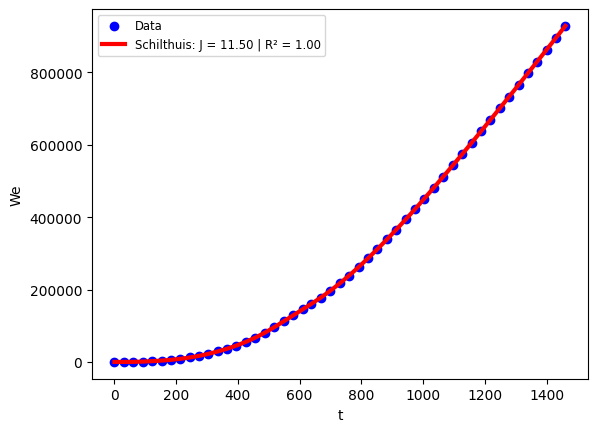

In [220]:
train["We_pred1"]=fittedData1
# train["We_pred2"]=fittedData2
# train["We_pred3"]=fittedData3

plt.scatter(t, We_est, label="Data", color="blue")
plt.plot(t, fittedData1, label=f"Schilthuis: J = {popt1[0]:0.2f} | R\N{SUPERSCRIPT TWO} = {r2_1:.2f}", color="red", linewidth=3)
# plt.plot(t, fittedData2, label=f"Hurst Mod.: C = {popt2[0]:0.2f} ; a = {popt2[1]:0.3f} | R\N{SUPERSCRIPT TWO} = {r2_2:.2f}", color="green", linewidth=3)
# plt.plot(t, fittedData3, label=f"Fetkovich: Wei = {popt3[0]:0.2f} ; J = {popt3[1]:0.3f} | R\N{SUPERSCRIPT TWO} = {r2_3:.2f}", color="orange", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("We")
plt.show()

<ipython-input-221-34f80e1a0770>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pimt[i]=pimt[i-1]+(p[0]-pmed)*(t[i]-t[i-1])


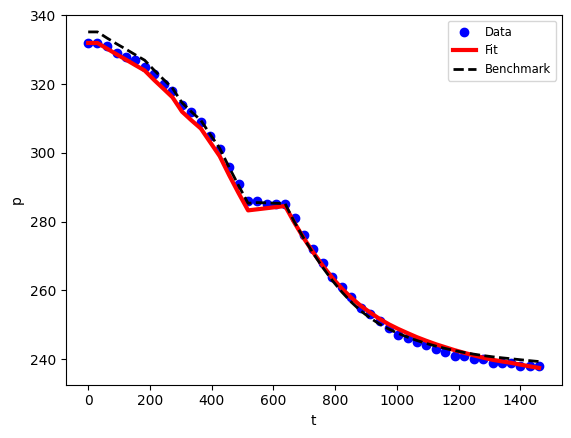

In [221]:
#Otimização

p_prev=np.zeros(len(t))
we_prev=np.zeros(len(t))
pimt=np.zeros(len(t))

def f_sch(pn, i):
    pmed=(p[i-1]+pn)/2
    pimt[i]=pimt[i-1]+(p[0]-pmed)*(t[i]-t[i-1])
    Sch=popt1[0]*pimt[i]
    return Sch

def f_ebm(pn, i):
    Bo=bob+co*bob*(pb-pn)
    Bg=1.40676*pn**(-1.04229)
    F=npp[i]*(Bo+(rp[i]-Rsi)*Bg)+(wp[i]-winj[i])*Bw
    Eo=Bo-bo[0]
    Efw=bo[0]*((cf+cw*Swi)/(1-Swi))*(p[0]-pn)
    EBM=F-N_est*(Eo+Efw)
    return EBM

for i in range(len(t)):
    if p[i] == p[0]:
        p_prev[i]=p[0]
        we_prev[i]=0
        pimt[i]=0
    else:
        pn=p[i-1]
        def f_obj(pn):
            Aquif=f_sch(pn, i)
            EBM=f_ebm(pn, i)
            return(EBM-Aquif)
        result=f_obj(pn)
        const = {'type':'eq', 'fun': f_obj}
        result=minimize(f_obj, pn, constraints=const)
        p_prev[i]=result.x[0]

plt.scatter(t, p, label="Data", color="blue")
plt.plot(t, p_prev, label="Fit", color="red", linewidth=3)
plt.plot(t, df["Press_b"], label="Benchmark", color="black", linewidth=2, linestyle='--')
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("p")
plt.show()